Install PheCAP

In [1]:
rm(list=ls())
install.packages("devtools")
devtools::install_github("https://github.com/celehs/PheCAP/", ref="tutorial", force=T)
library(PheCAP)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done





✔  checking for file ‘/tmp/RtmpnqsEzD/remotes1b7e2e50c2d1/celehs-PheCAP-da18434/DESCRIPTION’
─  preparing ‘PheCAP’:
✔  checking DESCRIPTION meta-information
─  installing the package to process help pages
─  saving partial Rd database (6.7s)
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘PheCAP_1.2.2.tar.gz’
   


Load data

In [2]:
data(ehr_data)
data <- PhecapData(ehr_data, "healthcare_utilization", "label", 0.4, patient_id = "patient_id")
data

PheCAP Data
Feature: 10000 observations of 587 variables
Label: 119 yes, 62 no, 9819 missing
Size of training samples: 109
Size of validation samples: 72

In [3]:
head(data$frame)

,label,main_ICD,main_NLP,healthcare_utilization,COD1,COD2,COD3,COD4,COD5,COD6,⋯,NLP565,NLP566,NLP567,NLP568,NLP569,NLP570,NLP571,NLP572,NLP573,NLP574
,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,NA,1,0,25,1,1,1,1,1,1,⋯,0,0,0,0,0,0,0,0,0,0
2,NA,41,157,187,71,31,29,2,2,11,⋯,0,2,0,1,0,0,0,0,0,0
3,NA,4,1,138,20,11,6,0,0,13,⋯,0,0,31,0,0,0,0,0,0,0
4,NA,0,0,67,1,1,1,0,3,6,⋯,0,0,0,1,0,0,0,0,0,0
5,NA,0,0,9,1,0,0,0,0,0,⋯,0,0,0,1,0,0,0,0,0,0
6,NA,4,2,4,0,0,1,0,1,0,⋯,0,0,0,2,0,0,0,0,0,0


Specify the surrogate used for surrogate-assisted feature extraction (SAFE). The typical way is to specify a main ICD code, a main NLP CUI, as well as their combination. In some cases one may want to define surrogate through lab test. The default lower_cutoff is 1, and the default upper_cutoff is 10. Feel free to change the cutoffs based on domain knowledge.

In [4]:
surrogates <- list(
  PhecapSurrogate(
    variable_names = "main_ICD",
    lower_cutoff = 1, upper_cutoff = 10),
  PhecapSurrogate(
    variable_names = "main_NLP",
    lower_cutoff = 1, upper_cutoff = 10),
  PhecapSurrogate(
    variable_names = c("main_ICD", "main_NLP"),
    lower_cutoff = 1, upper_cutoff = 10))

Run surrogate-assisted feature extraction (SAFE) and show result.

In [5]:
system.time(feature_selected <- phecap_run_feature_extraction(data, surrogates))

   user  system elapsed 
206.984   0.052 207.053 

In [6]:
feature_selected

Feature(s) selected by surrogate-assisted feature extraction (SAFE)
[1] "main_ICD" "main_NLP" "NLP56"    "NLP93"    "NLP160"   "NLP161"   "NLP306"  
[8] "NLP403"   "NLP536"  

Train phenotyping model and show the fitted model, with the AUC on the training set as well as random splits

In [8]:
suppressWarnings(model <- phecap_train_phenotyping_model(data, surrogates, feature_selected))
model

Phenotyping model:
$lasso_bic
           (Intercept)               main_ICD               main_NLP 
             0.8165615              2.3789729              2.7761557 
     main_ICD&main_NLP healthcare_utilization                  NLP56 
            -1.6390179             -1.3316767              0.0000000 
                 NLP93                 NLP160                 NLP161 
            -1.6091941              0.0000000              0.0000000 
                NLP306                 NLP403                 NLP536 
             0.0000000              0.0000000              0.9910775 

AUC on training data: 0.988 
Average AUC on random splits: 0.971 

Try a different model

In [12]:
install.packages("e1071")
library(e1071)
suppressWarnings(model2 <- phecap_train_phenotyping_model(data, surrogates, feature_selected, method="svm"))
model2

also installing the dependency ‘proxy’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



Phenotyping model:
$svm

Call:
best.svm(x = x, y = y1, gamma = c(0.2, 1, 5)/ncol(x), cost = 4^(-5L:5L), 
    kernel = "radial", type = "C-classification", probability = TRUE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  4 

Number of Support Vectors:  48


AUC on training data: 0.988 
Average AUC on random splits: 0.967 

Validate phenotyping model using validation label

In [21]:
options(warn=-1)

In [22]:
validation <- phecap_validate_phenotyping_model(data, model)
validation

AUC on validation data: 0.867 
AUC on training data: 0.988 
Average AUC on random splits: 0.971 

Show ROC table

In [23]:
round(validation$valid_roc[validation$valid_roc[, "FPR"] <= 0.2, ], 3)

cutoff,pos.rate,FPR,TPR,PPV,NPV,F1
1.000,0.007,0.000,0.245,1.000,0.353,0.394
0.988,0.319,0.000,0.356,1.000,0.390,0.526
0.975,0.361,0.000,0.468,1.000,0.436,0.637
0.966,0.375,0.048,0.545,0.965,0.463,0.697
0.959,0.375,0.048,0.603,0.969,0.497,0.743
0.936,0.458,0.048,0.661,0.971,0.536,0.786
0.861,0.542,0.048,0.718,0.973,0.582,0.827
0.785,0.569,0.048,0.776,0.975,0.637,0.864
0.772,0.583,0.095,0.784,0.952,0.633,0.860
0.770,0.583,0.095,0.784,0.952,0.633,0.860


Plot ROC curve

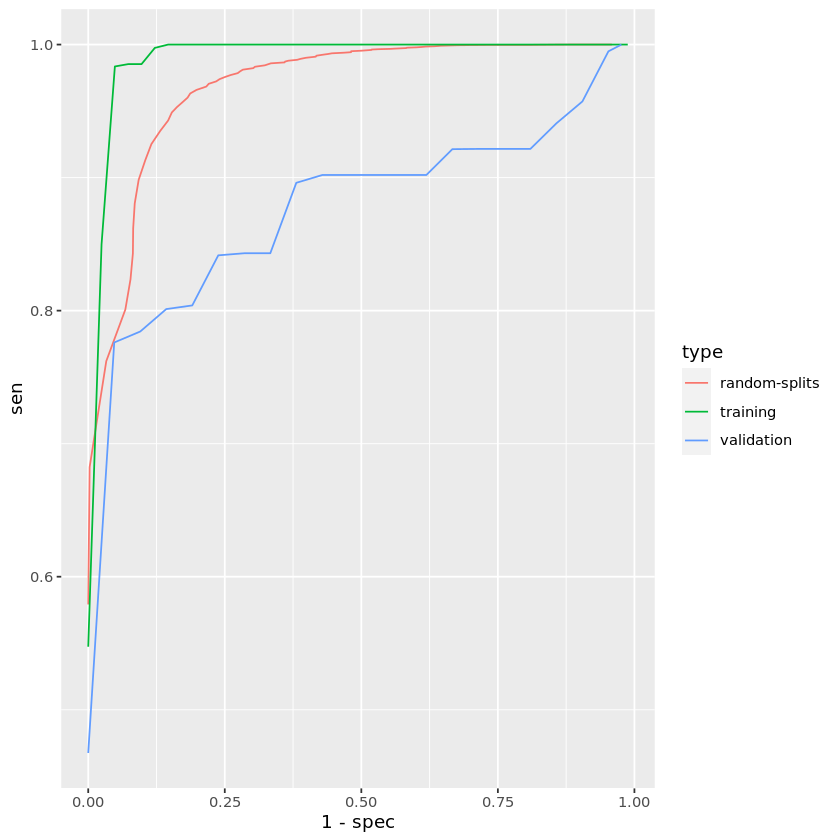

In [24]:
phecap_plot_roc_curves(validation)

Which cutoff correspond to FPR closest to 0.05

In [25]:
idx <- which.min(abs(validation$valid_roc[, "FPR"] - 0.05))
cut.fpr95 <- validation$valid_roc[idx, "cutoff"]

Apply the model to all the patients to obtain predicted phenotype

In [26]:
phenotype <- phecap_predict_phenotype(data, model)
case_status <- ifelse(phenotype$prediction >= cut.fpr95, 1, 0)
predict.table <- cbind(phenotype, case_status)
predict.table[1:10, ]

,patient_id,prediction,case_status
,<int>,<dbl>,<dbl>
1,1,1.467910e-01,0
2,2,9.999938e-01,1
3,3,1.828879e-01,0
4,4,9.384499e-05,0
5,5,1.649510e-02,0
6,6,9.803657e-01,1
7,7,8.645029e-03,0
8,8,2.602369e-04,0
9,9,3.652225e-01,0
